## Processing sensor data from Shale Hills CZO SPVF site ##

Marc Berghouse 8/8/2020

This array includes:
- Apogee Instruments SO-110 O2 sensors
- Eosense EosGP CO2 sensors
- OTT Pluvio rain gauge
- Custom built well
- nested-suction lysimeter (1900 series, SoilMoisture Equipment Corp., Santa Barbara, CA)
- ThiesCLIMA Laser Precipitation Monitor (LPM)

## At 50cm CO2lo is much different than CO2hi. Not sure if we should combine differently


In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt




# Define filenames
infile1 = "../../raw_data/Shale Hills/SPVF/SPVF_SiTS_CO2.csv" 
infile2 = "../../raw_data/Shale Hills/SPVF/ShaleHills_precipitation.csv" 
infile3 = "../../raw_data/Shale Hills/SPVF/ShaleHills_pCO2.csv" 
infile4 = "../../raw_data/Shale Hills/SPVF/ShaleHills_Geochem_2006_11.csv" 
infile5 = "../../raw_data/Shale Hills/SPVF/SPVF_SiTS_Oxygen.csv" 
infile6 = "../../raw_data/Shale Hills/SPVF/NO3_NH4_DOC_2013.xlsx" 
infile7 = "../../raw_data/Shale Hills/SPVF/NO3_NH4_DOC_2014.xlsx" 




# Read the .dat files as Pandas dataframes and load in the date/times
df1 = pd.read_csv(infile1, na_values='NAN', parse_dates=[0], index_col=0) 
df2 = pd.read_csv(infile2, na_values='NAN', parse_dates=[0], index_col=0) 
#df3 = pd.read_csv(infile3, na_values='NAN',  index_col=['Sample Collection Date']) 
#df4 = pd.read_csv(infile4, na_values='NAN', parse_dates=[0], index_col=1) 
df5 = pd.read_csv(infile5, na_values='NAN', parse_dates=[0], index_col=0) 
#df6 = pd.read_excel(infile6, sheet_name=1, na_values='NAN', parse_dates=[0], index_col=1) 
#df7 = pd.read_excel(infile7, sheet_name=1, na_values='NAN', parse_dates=[0], index_col=1) 





In [2]:
#Rename all columns for df1 with format "var_depth.unit" 
#mask erroneous values in df1
#I was able to mask values based on percent change from the previous value, but the graph still looks bad and I am wondering if this CO2 data is usable at all
df1=df1.drop(columns='RecNum')
df1.columns=["CO2lo_50cm.ppm", "CO2hi_50cm.ppm", "GPTemp_50cm.deg.C", "CO2lo_70cm.ppm",  "CO2hi_70cm.ppm" , "GPTemp_70cm.deg.C"]
df1.mask(df1<=-0.001, inplace=True)
df1.loc['2020-6-5':'2020-6-27']=np.nan


df1



,CO2lo_50cm.ppm,CO2hi_50cm.ppm,GPTemp_50cm.deg.C,CO2lo_70cm.ppm,CO2hi_70cm.ppm,GPTemp_70cm.deg.C
TmStamp,,,,,,
2020-03-18 19:30:00,827.0,2461.3069,7.103,2795.0,2783.2964,7.362
2020-03-18 19:45:00,833.0,2482.1650,7.234,2820.0,2805.1797,7.508
2020-03-18 20:00:00,833.0,2507.4565,7.386,2818.0,2805.7119,7.843
2020-03-18 20:15:00,844.0,2511.4934,7.630,2849.0,2842.4077,7.709
2020-03-18 20:30:00,846.0,2517.3999,7.627,2873.0,2868.6086,7.706
...,...,...,...,...,...,...
2020-07-21 15:15:00,NaN,NaN,NaN,NaN,NaN,NaN
2020-07-21 15:30:00,NaN,NaN,NaN,NaN,NaN,NaN
2020-07-21 15:45:00,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
df5=df5.drop(columns='RecNum')
df5=df5.drop(columns='Sensor_50_mv_Avg')
df5=df5.drop(columns='Sensor_70_mv_Avg')

df5.columns=["O2_50cm.percent.0-100", "ApogeeTemp_50cm.deg.C", "O2_70cm.percent.0-100", "ApogeeTemp_70cm.deg.C" ]
df5.mask(df1<=0, inplace=True)
#df5.loc['2020-6-5':'2020-6-27']=np.nan
df5

,O2_50cm.percent.0-100,ApogeeTemp_50cm.deg.C,O2_70cm.percent.0-100,ApogeeTemp_70cm.deg.C
TmStamp,,,,
2020-03-18 19:20:00,21.408501,5.950000,21.065500,5.950000
2020-03-18 19:22:00,21.403999,5.875000,21.061499,5.950000
2020-03-18 19:24:00,21.398499,5.950000,21.056000,6.000000
2020-03-18 19:26:00,21.394999,5.925000,21.053249,6.000000
2020-03-18 19:28:00,21.392000,5.950000,21.049500,6.000000
...,...,...,...,...
2020-07-21 15:15:00,NaN,19.299997,NaN,18.200001
2020-07-21 15:30:00,NaN,19.299997,NaN,18.200001
2020-07-21 15:45:00,NaN,19.299997,NaN,18.200001


## Currently only using sensor data. All markdown cells correspond to manual data

#Rename all columns for df2 with format "var_depth.unit" 
#mask erroneous values in df2
df2=df2.drop(columns='Correlation')
df2=df2.drop(columns='Comment')
df2.columns=["Precipitation.mm", "Device"]

#creating an id for each unique device so that it can be plotted on colormap
d = {ni: indi for indi, ni in enumerate(set(df2['Device']))}
df2['device_numbers'] = [d[ni] for ni in df2['Device']]

fig,ax=plt.subplots()
fig.set_size_inches(14,5)
im=ax.scatter(df2.index, df2['Precipitation.mm'], c=df2['device_numbers'])
cbar=fig.colorbar(im)

#df2

#Rename all columns for df3 with format "var_depth.unit" 
#mask erroneous values in df3
#separate columns based on depth. Is this actually necessary?
#drop unnecessary columns
df3=df3.loc[df3['Site (1)'] == 'SPVF'] 
df3['CO2_10cm.ppm']=np.where(df3['Depth (m)'] == .1, df3['pCO2 (ppmv)'], np.nan)
df3['CO2_20cm.ppm']=np.where(df3['Depth (m)'] == .2, df3['pCO2 (ppmv)'], np.nan)
df3['CO2_40cm.ppm']=np.where(df3['Depth (m)'] == .4, df3['pCO2 (ppmv)'], np.nan)
df3['CO2_0cm.ppm']=np.where(df3['Depth (m)'] == .0, df3['pCO2 (ppmv)'], np.nan)
df3=df3.drop(columns='Site (2)')
df3=df3.drop(columns='Sample Collection Time')
df3=df3.drop(columns='Tech')
df3=df3.drop(columns='Elevation (m)')
#df3=df3.drop(columns='pCO2 (ppmv)')
#df3=df3.drop(columns='Depth (m)')
df3=df3.drop(columns='Site (1)')


fig,ax=plt.subplots()
im=ax.scatter(df3.index, df3['pCO2 (ppmv)'], c=df3['Depth (m)'])
cbar=fig.colorbar(im)
df3

#Rename all columns for df4 with format "var_depth.unit"
#select correct site
#mask erroneous values in df4
df4=df4.loc[df4['SiteCode'] == 'SPVF'] 
df4=df4.drop(columns='RecordNum')
df4=df4.drop(columns='SampleNumber')
df4=df4.drop(columns='SiteCode')
#df4.mask(df4<=-0.1, inplace=True)
df4['DOC'].mask(df4['DOC']<=-1, inplace=True)
df4['pH'].mask(df4['pH']<=-1, inplace=True)


In [4]:
#is there a way to do this without 3 lines of code? my pd.concat code gives me a dataframe with incorrect timestamps 
df=pd.concat([df1,df2, df5], sort=False)

#df1_2 = df1.join(df2, how='outer')

df

,CO2lo_50cm.ppm,CO2hi_50cm.ppm,GPTemp_50cm.deg.C,CO2lo_70cm.ppm,CO2hi_70cm.ppm,GPTemp_70cm.deg.C,Total_Precip_mm,Device,Correlation,Comment,O2_50cm.percent.0-100,ApogeeTemp_50cm.deg.C,O2_70cm.percent.0-100,ApogeeTemp_70cm.deg.C
TmStamp,,,,,,,,,,,,,,
2020-03-18 19:30:00,827.0,2461.3069,7.103,2795.0,2783.2964,7.362,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-18 19:45:00,833.0,2482.1650,7.234,2820.0,2805.1797,7.508,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-18 20:00:00,833.0,2507.4565,7.386,2818.0,2805.7119,7.843,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-18 20:15:00,844.0,2511.4934,7.630,2849.0,2842.4077,7.709,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-18 20:30:00,846.0,2517.3999,7.627,2873.0,2868.6086,7.706,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-07-21 15:15:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.299997,NaN,18.200001
2020-07-21 15:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.299997,NaN,18.200001
2020-07-21 15:45:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.299997,NaN,18.200001


df['Nitrate'].mask(df['Nitrate']<=-1, inplace=True)

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(16,12), tight_layout=True)
im=ax2.scatter(df.index, df['pH'], c=df['Depth'])

im=ax1.scatter(df.index, df['pCO2 (ppmv)'], c=df['Depth (m)'])
cbar=fig.colorbar(im)


C:\Users\marcb\anaconda3\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


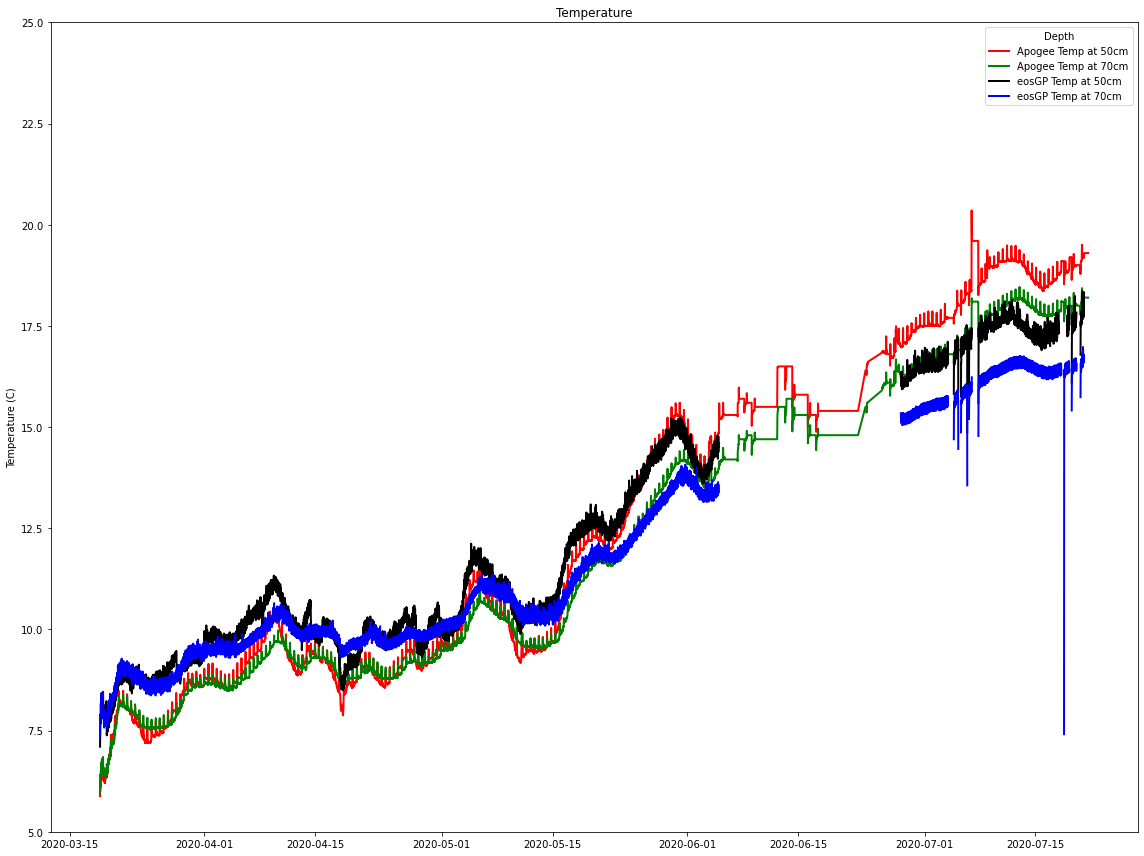

In [5]:
# Plot the datalogger parameters: battery voltage, panel temperature, enclosure temperature, and barometric pressure
fig, ( ax2) = plt.subplots(1, 1, sharex=True, figsize=(16,12), tight_layout=True)

# Apogee SO-110 differntial voltages
#ax1.plot(df1.index, df1['DiffVolt_30cm.mV'], 'b', linewidth=2, label='Differential Voltage at 30cm')
#ax1.plot(df1.index, df1['DiffVolt_140cm.mV'], 'g', linewidth=2, label='Differential Voltage at 140cm')
#ax1.set(ylabel='Voltage', title='Voltage')#, ylim=[36,48])
#ax1.axhline(y=10, linestyle='--', color='k', alpha=0.5)
#ax1.legend(title='Depth', loc='best')

# datalogger temperatures
df['GPTemp_50cm.deg.C'].loc['2020-7-18']=np.nan
ax2.plot(df.index, df["ApogeeTemp_50cm.deg.C"], 'r', linewidth=2, label='Apogee Temp at 50cm')
ax2.plot(df.index, df["ApogeeTemp_70cm.deg.C"], 'g', linewidth=2, label='Apogee Temp at 70cm')
ax2.plot(df.index, df['GPTemp_50cm.deg.C'], 'k', linewidth=2, label='eosGP Temp at 50cm')
ax2.plot(df.index, df['GPTemp_70cm.deg.C'], 'b', linewidth=2, label='eosGP Temp at 70cm')
ax2.set(ylabel='Temperature (C)', title='Temperature', ylim=[5,25])
ax2.legend(title='Depth', loc='best')


In [6]:
#Drop bad and extraneous data 
df['GPTemp_70cm.deg.C'].loc['2020-7-18':'2020-7-19']=np.nan

df=df.drop(columns='ApogeeTemp_50cm.deg.C')
df=df.drop(columns='ApogeeTemp_70cm.deg.C')
df=df.drop(columns='Device')
df=df.drop(columns='Correlation')
df=df.drop(columns='Comment')



C:\Users\marcb\anaconda3\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


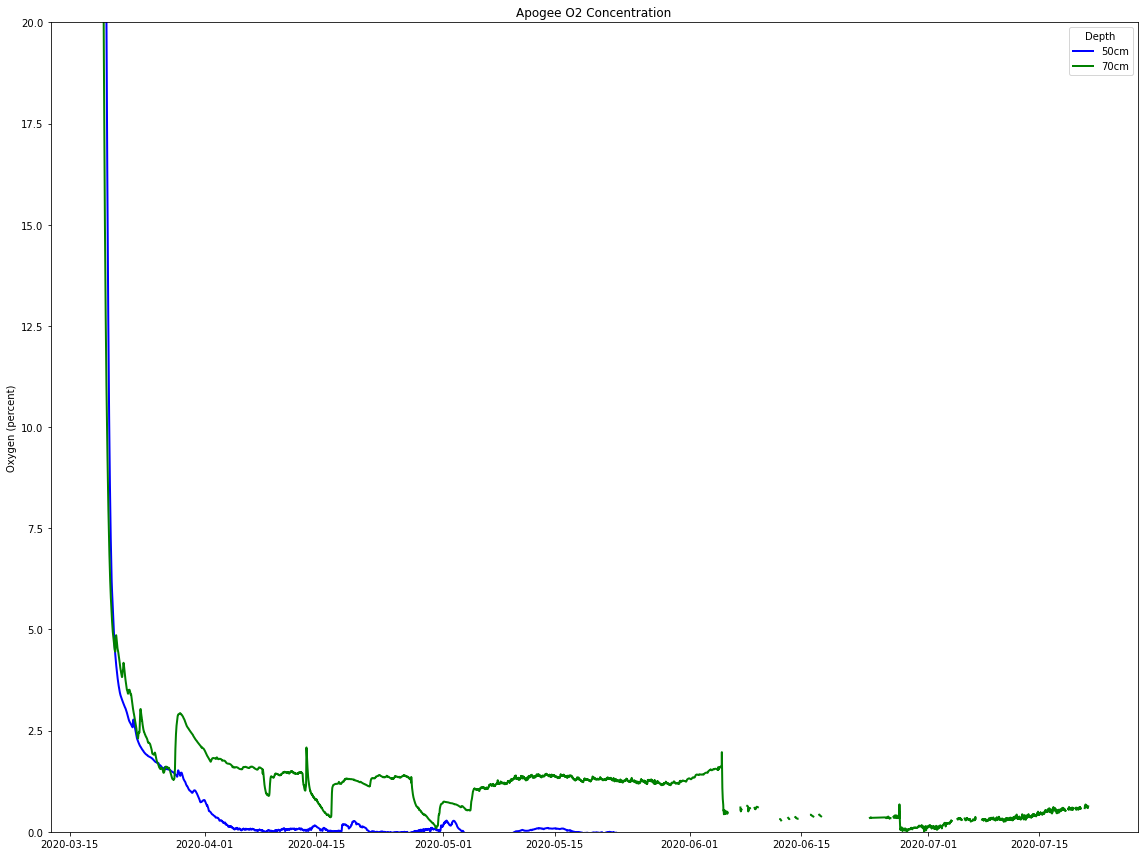

In [7]:
fig, (ax2) = plt.subplots(1, figsize=(16,12), sharex=True, tight_layout=True)
#ax1.plot(df1.index, df1.iloc[:,6], 'b', linewidth=2)
#ax1.set(ylabel='Temperature (C)', title='Apogee Temperature at 30cm')

ax2.plot(df.index, df['O2_50cm.percent.0-100'], 'b', linewidth=2, label='50cm')
ax2.set(ylabel='Oxygen (percent)', title='Apogee O2 Concentration', ylim=(0,20))
ax2.plot(df.index, df['O2_70cm.percent.0-100'], 'g', linewidth=2, label='70cm')
ax2.legend(title='Depth', loc='best')



In [8]:
#Combine CO2lo and CO2hi


mask = df['CO2lo_50cm.ppm'] < 5000
df.loc[mask, 'CO2_50cm.ppm'] = df.loc[mask, 'CO2lo_50cm.ppm']
df.loc[~mask, 'CO2_50cm.ppm'] = df.loc[~mask, 'CO2hi_50cm.ppm']
mask2 = df['CO2lo_70cm.ppm'] < 5000
df.loc[mask2, 'CO2_70cm.ppm'] = df.loc[mask2, 'CO2lo_70cm.ppm']
df.loc[~mask2, 'CO2_70cm.ppm'] = df.loc[~mask2, 'CO2hi_70cm.ppm']

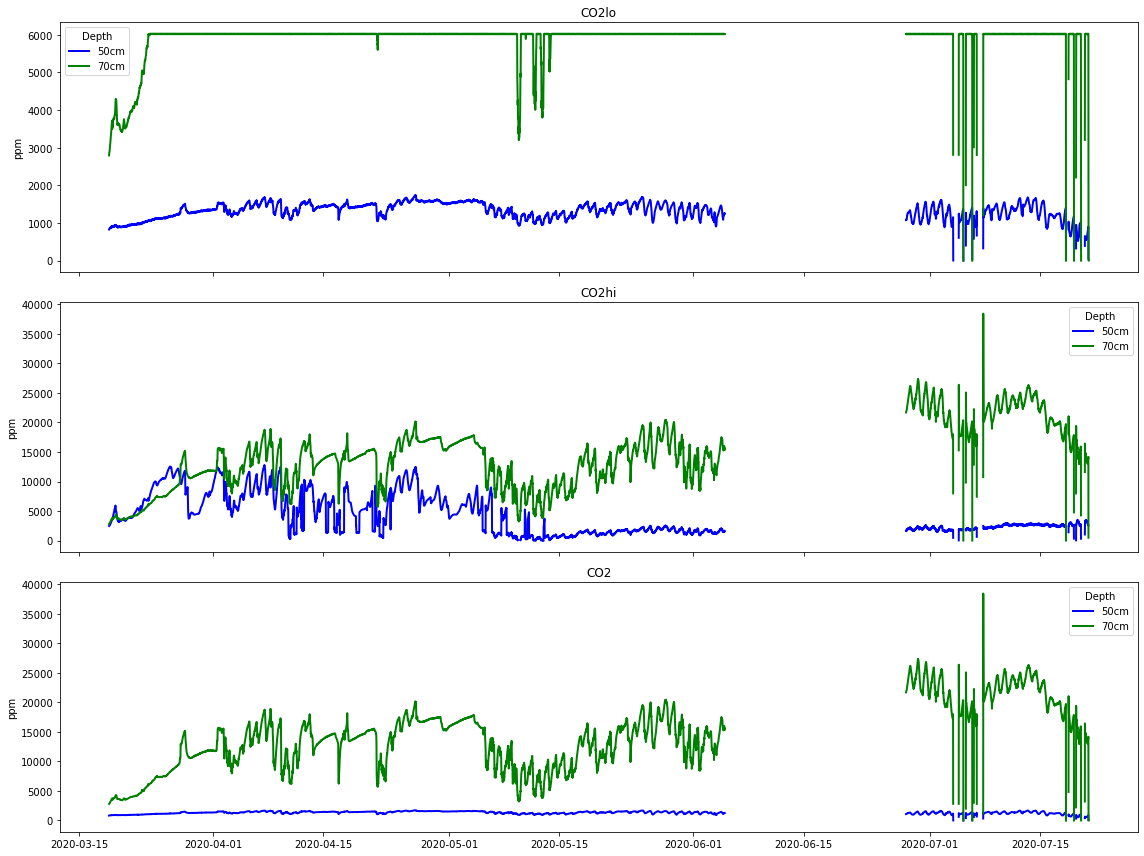

In [9]:
#Correct and plot CO2 data 

fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(16,12), sharex=True, tight_layout=True)
ax1.plot(df.index, df['CO2lo_50cm.ppm'], 'b', linewidth=2, label='50cm')
ax1.plot(df.index, df['CO2lo_70cm.ppm'], 'g', linewidth=2, label='70cm')
ax1.set(ylabel='ppm', title='CO2lo')
ax1.legend(title='Depth', loc='best')
ax2.plot(df.index, df['CO2hi_50cm.ppm'], 'b', linewidth=2, label='50cm')
ax2.plot(df.index, df['CO2hi_70cm.ppm'], 'g', linewidth=2, label='70cm')
ax2.set(ylabel='ppm', title='CO2hi')
ax2.legend(title='Depth', loc='best')
ax3.plot(df.index, df['CO2_50cm.ppm'], 'b', linewidth=2, label='50cm')
ax3.plot(df.index, df['CO2_70cm.ppm'], 'g', linewidth=2, label='70cm')
ax3.set(ylabel='ppm', title='CO2')
ax3.legend(title='Depth', loc='best')

In [10]:
#Drop bad and extraneous CO2 data 
df=df.drop(columns='CO2lo_70cm.ppm')
df=df.drop(columns='CO2hi_70cm.ppm')
df=df.drop(columns='CO2lo_50cm.ppm')
df=df.drop(columns='CO2hi_50cm.ppm')

In [11]:
output=df.copy()
today = dt.date.today()
outfile = '../../processed_data/Shale Hills/SPVF_processed.csv'
output.to_csv(outfile, na_rep=-99999, index_label='DateTime.EST')

In [12]:
output

,GPTemp_50cm.deg.C,GPTemp_70cm.deg.C,Total_Precip_mm,O2_50cm.percent.0-100,O2_70cm.percent.0-100,CO2_50cm.ppm,CO2_70cm.ppm
TmStamp,,,,,,,
2020-03-18 19:30:00,7.103,7.362,NaN,NaN,NaN,827.0,2795.0
2020-03-18 19:45:00,7.234,7.508,NaN,NaN,NaN,833.0,2820.0
2020-03-18 20:00:00,7.386,7.843,NaN,NaN,NaN,833.0,2818.0
2020-03-18 20:15:00,7.630,7.709,NaN,NaN,NaN,844.0,2849.0
2020-03-18 20:30:00,7.627,7.706,NaN,NaN,NaN,846.0,2873.0
...,...,...,...,...,...,...,...
2020-07-21 15:15:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-07-21 15:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-07-21 15:45:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
